<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/Pytorch/Pytorch_Common_code_snippets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks: https://zhuanlan.zhihu.com/p/104019160
# 1. 基本配置

## Libaray

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))

1.11.0+cu113
11.3
8200
Tesla P100-PCIE-16GB


## 可复现性
在硬件设备（CPU、GPU）不同时，完全的可复现性无法保证，即使随机种子相同。但是，在同一个设备上，应该保证可复现性。具体做法是，在程序开始的时候固定torch的随机种子，同时也把numpy的随机种子固定。

In [2]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.backends = False

## 显卡设置
如果只需要一张显卡

In [3]:
# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

如果需要指定多张显卡，比如0，1号显卡。

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

也可以在命令行运行代码时设置显卡：

`CUDA_VISIBLE_DEVICES=0,1 python train.py`

清除显存

In [ ]:
torch.cuda.empty_cache()

也可以使用在命令行重置GPU的指令

`nvidia-smi --gpu-reset -i [gpu_id]`

# 2. 张量(Tensor)处理
## 张量的数据类型
PyTorch有9种CPU张量类型和9种GPU张量类型。


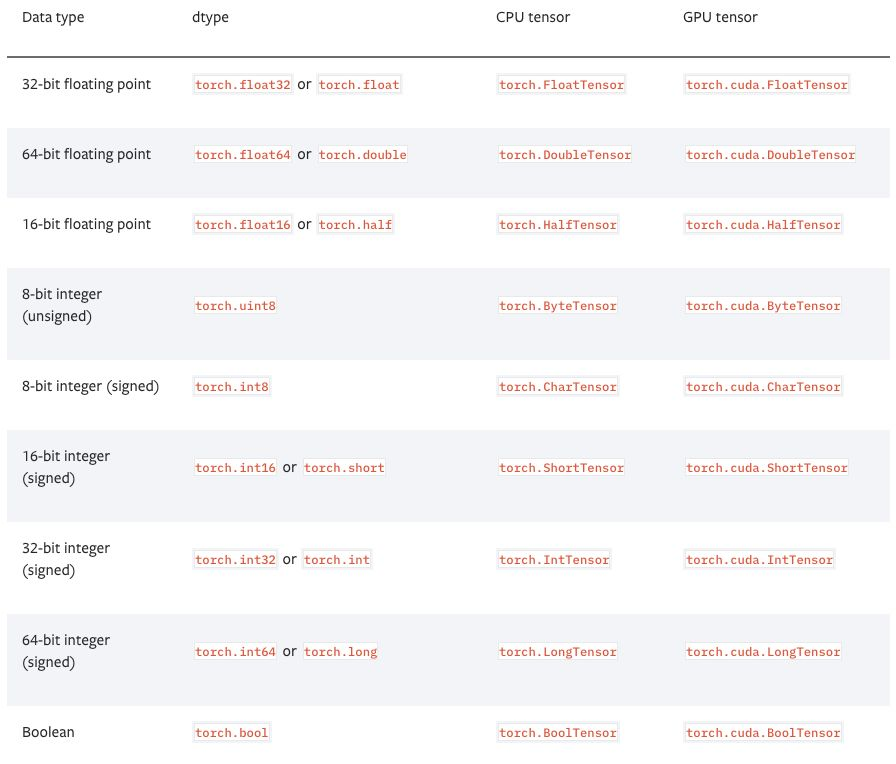

## 张量基本信息

In [ ]:
tensor = torch.randn(3,4,5)
print(tensor.type())  # 数据类型
print(tensor.size())  # 张量的shape，是个元组
print(tensor.dim())   # 维度的数量

torch.FloatTensor
torch.Size([3, 4, 5])
3


## 命名张量
张量命名是一个非常有用的方法，这样可以方便地使用维度的名字来做索引或其他操作，大大提高了可读性、易用性，防止出错。

In [ ]:
# 在PyTorch 1.3之前，需要使用注释
# Tensor[N, C, H, W]

images = torch.randn(32, 3, 56, 56)
images.sum(dim=1)
images.select(dim=1,index=0).shape

torch.Size([32, 56, 56])

In [ ]:
# PyTorch 1.3之后
#useful
NCHW = ["N", "C", "H", "W"]
images = torch.randn(32,3,56,56,names=NCHW)
images.sum('C')
images.select('C', index=0).shape

torch.Size([32, 56, 56])

In [ ]:
# 也可以这么设置
tensor = torch.rand(3,4,28,28,names=('C', 'N', 'H', 'W')) #Tensor with shape torch.Size([3, 4, 28, 28])
# 使用align_to可以对维度方便地排序
tensor_align = tensor.align_to('N', 'C', 'H', 'W') #Tensor with shape torch.Size([4, 3, 28, 28])

## 数据类型转换

In [ ]:
# 设置默认类型，pytorch中的FloatTensor远远快于DoubleTensor

torch.set_default_tensor_type(torch.FloatTensor)


array = np.arange(1,20)
tensor = torch.Tensor(array)

##类型转换
tensor_cuda = tensor.cuda()
tensor_cpu = tensor.cpu()
tensor_float = tensor.float()
tensor_long = tensor.long()

print('\n tensor.cuda() type is', tensor_cuda.type(), 
  '\n tensor.cpu() type is', tensor_cpu.type(),
  '\n tensor.float() type is', tensor_float.type(),
  '\n tensor.long() type is', tensor_long.type())


 tensor.cuda() type is torch.cuda.FloatTensor 
 tensor.cpu() type is torch.FloatTensor 
 tensor.float() type is torch.FloatTensor 
 tensor.long() type is torch.LongTensor


## torch.Tensor与np.ndarray转换
除了CharTensor，其他所有CPU上的张量都支持转换为numpy格式然后再转换回来。

In [ ]:
ndarray = tensor.cpu().numpy()
tensor = torch.from_numpy(ndarray).float()
tensor = torch.from_numpy(ndarray.copy()).float() # If ndarray has negative stride.

## 从只包含一个元素的张量中提取值

In [ ]:
value = torch.rand(1).item()
value

0.892909049987793

## 张量形变

In [ ]:
# 在将卷积层输入全连接层的情况下通常需要对张量做形变处理，
# 相比torch.view，torch.reshape可以自动处理输入张量不连续的情况。
tensor = torch.randn(2,3,4)
tensor_reshape = tensor.reshape(6,4)

## 打乱顺序

In [ ]:
tensor_int = torch.rand(2,3,4)
tensor_shuffle = tensor_int[torch.randperm(tensor_int.size(0))]
print(tensor_int)
print(tensor_shuffle)

tensor([[[0.1441, 0.5766, 0.8694, 0.6762],
         [0.3617, 0.9431, 0.5471, 0.1201],
         [0.6340, 0.3477, 0.6328, 0.2184]],

        [[0.1997, 0.2257, 0.5535, 0.7637],
         [0.8562, 0.0591, 0.9633, 0.1631],
         [0.1848, 0.1515, 0.6405, 0.3045]]])
tensor([[[0.1997, 0.2257, 0.5535, 0.7637],
         [0.8562, 0.0591, 0.9633, 0.1631],
         [0.1848, 0.1515, 0.6405, 0.3045]],

        [[0.1441, 0.5766, 0.8694, 0.6762],
         [0.3617, 0.9431, 0.5471, 0.1201],
         [0.6340, 0.3477, 0.6328, 0.2184]]])


In [ ]:
#返回一个随机数
torch.randperm(8)

tensor([3, 7, 5, 1, 6, 4, 0, 2])

水平翻转

In [ ]:
# pytorch不支持tensor[::-1]这样的负步长操作，水平翻转可以通过张量索引实现
# 假设张量的维度为[N, D, H, W].

#tensor = torch.randn(64, 3, 28, 28, names=['N','D','H','W'])
tensor = torch.randn(3, 4, 2, 2)
tensor_verse =  tensor[:,:,:,torch.arange(tensor.size(3) - 1, -1, -1).long()]
print(tensor)
print(tensor_verse)

tensor([[[[-0.7961,  0.4306],
          [-0.0204, -0.0738]],

         [[ 1.0387, -1.3586],
          [ 0.5468,  0.0324]],

         [[-0.6373, -0.5410],
          [-1.2767,  1.5713]],

         [[-1.0333,  0.4070],
          [-0.1232,  0.3596]]],


        [[[-0.1806, -0.0979],
          [ 0.9137, -0.5579]],

         [[ 1.4176,  0.3219],
          [-0.3256,  2.7724]],

         [[ 1.1399,  0.0338],
          [-0.8647,  1.1273]],

         [[-0.5441, -1.6958],
          [-1.3371, -1.3961]]],


        [[[ 0.1791,  0.2794],
          [-1.5565, -1.7754]],

         [[-0.0564, -2.0580],
          [-1.8449,  1.3184]],

         [[-0.3647,  0.8015],
          [-1.1537, -0.9234]],

         [[ 1.2548,  0.9174],
          [-1.1107,  0.2180]]]])
tensor([[[[ 0.4306, -0.7961],
          [-0.0738, -0.0204]],

         [[-1.3586,  1.0387],
          [ 0.0324,  0.5468]],

         [[-0.5410, -0.6373],
          [ 1.5713, -1.2767]],

         [[ 0.4070, -1.0333],
          [ 0.3596, -0.1232]]],


 

## 复制张量

In [ ]:
# Operation|  New/Shared memory | Still in computation graph |

tensor.clone()  #|  New   |          Yes               |
tensor.detach()   # |      Shared        |          No                |
tensor.detach.clone()() # |        New         |          No                |

tensor([[[[-0.7961,  0.4306],
          [-0.0204, -0.0738]],

         [[ 1.0387, -1.3586],
          [ 0.5468,  0.0324]],

         [[-0.6373, -0.5410],
          [-1.2767,  1.5713]],

         [[-1.0333,  0.4070],
          [-0.1232,  0.3596]]],


        [[[-0.1806, -0.0979],
          [ 0.9137, -0.5579]],

         [[ 1.4176,  0.3219],
          [-0.3256,  2.7724]],

         [[ 1.1399,  0.0338],
          [-0.8647,  1.1273]],

         [[-0.5441, -1.6958],
          [-1.3371, -1.3961]]],


        [[[ 0.1791,  0.2794],
          [-1.5565, -1.7754]],

         [[-0.0564, -2.0580],
          [-1.8449,  1.3184]],

         [[-0.3647,  0.8015],
          [-1.1537, -0.9234]],

         [[ 1.2548,  0.9174],
          [-1.1107,  0.2180]]]])

## 张量拼接

In [ ]:
'''
注意torch.cat和torch.stack的区别在于torch.cat沿着给定的维度拼接，
而torch.stack会新增一维。例如当参数是3个10x5的张量，torch.cat的结果是30x5的张量，
而torch.stack的结果是3x10x5的张量。
'''
list_of_tensors = [torch.rand(10,5) for _ in range(3)]
tensor_cat = torch.cat(list_of_tensors, dim=0) #Tensor with shape torch.Size([30, 5])
tensor_stack = torch.stack(list_of_tensors, dim=0) #Tensor with shape torch.Size([3, 10, 5])

## 将整数标签转为one-hot编码

In [ ]:
# pytorch的标记默认从0开始

tensor = torch.tensor([0,1,2,3])
N = tensor.size(0)
num_classes = 4
one_hot = torch.zeros(N, num_classes).long()
one_hot.scatter_(dim=1, index=torch.unsqueeze(tensor,dim=1), src=torch.ones(N, num_classes).long())

tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])

In [ ]:
index = torch.tensor([[0], [1], [2], [3]])
onehot = torch.zeros(4, 4)
onehot.scatter_(1, index, 1)
print(onehot)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In [ ]:
classes = 10
labels = torch.tensor(np.arange(10)).view(10,1)
input_tensor = torch.zeros(classes, classes)
dim = 1
src = 1 #tell 1 you should play input_tensor according to labels
one_hot = input_tensor.scatter_(1, labels, 1)
print(one_hot)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


## 得到非零元素

In [ ]:
torch.nonzero(tensor)               # index of non-zero elements
torch.nonzero(tensor==0)            # index of zero elements
torch.nonzero(tensor).size(0)       # number of non-zero elements
torch.nonzero(tensor == 0).size(0)  # number of zero elements

1

## 判断两个张量相等

In [ ]:
tensor_1_float = torch.randn(3,4)
tensor_2_float = torch.randn(3,4)
tensor1 = torch.rand(3,4)
tensor2 = torch.rand(3,4)
torch.allclose(tensor_1_float, tensor_2_float)  # float tensor
torch.equal(tensor1, tensor2)     # int tensor

False

## 张量扩展

In [ ]:
# Expand tensor of shape 64*512 to shape 64*512*7*7.

tensor = torch.rand(64,512)
torch.reshape(tensor, (64, 512, 1, 1)).expand(64, 512, 7, 7).shape

torch.Size([64, 512, 7, 7])

## 矩阵乘法

In [ ]:
# Matrix multiplcation: (m*n) * (n*p) * -> (m*p).
m, n, b, p = 4,6,2,7
tensor_m2_1 = torch.randn(m,n)
tensor_m2_2 = torch.randn(n,p)
result_mm = torch.mm(tensor_m2_1, tensor_m2_2)

print('Shape is :',result_mm.shape,'\n',result_mm)

# Batch matrix multiplication: (b*m*n) * (b*n*p) -> (b*m*p)
result_bm_1 = torch.randn(b,m,n)
result_bm_2 = torch.randn(b,n,p)
result_bm = torch.bmm(result_bm_1,result_bm_2)
print('Shape is :',result_bm.shape,'\n',result_bm)

## Element-wise multiplication.
tensor1 = torch.rand(3,4)
tensor2 = torch.rand(3,4)
print(tensor1)
print(tensor2)
print('Element-wise:')
print(tensor1*tensor2)

Shape is : torch.Size([4, 7]) 
 tensor([[ 0.2367, -0.0802,  0.9452, -0.9630,  0.0173, -0.0512,  1.1892],
        [ 0.1690, -2.1754, -0.1033,  2.8157,  0.5439,  0.1253,  0.8446],
        [-1.5980,  3.0385,  0.4911, -3.1982,  0.9138, -3.0697, -3.3186],
        [-2.4695,  3.3763, -0.4952, -5.0527, -1.6771, -3.1138, -1.1253]])
Shape is : torch.Size([2, 4, 7]) 
 tensor([[[ 3.9757,  0.2067,  1.5942,  0.7363, -0.8110, -4.8084, -0.2744],
         [ 1.4351,  0.3082,  1.3421,  0.4926, -0.8777, -1.7868, -0.7390],
         [-1.7616,  0.2007, -2.2239,  0.4709,  5.8644,  4.7134,  5.6867],
         [-7.0921,  2.7020,  2.6105,  5.1845,  2.1272, -1.8300, -3.9944]],

        [[-2.4923,  2.6803, -3.0524, -1.0829, -2.3861, -0.7222,  0.5155],
         [-2.3885,  5.3424, -0.7335, -0.5094, -2.4154, -5.0908,  2.2339],
         [-0.1608,  4.1478, -1.2360, -1.4012, -0.8220, -5.2332,  2.3381],
         [-5.6416,  2.6858, -0.0890,  1.8736, -3.6786, -3.0270,  0.6055]]])
tensor([[0.8464, 0.1618, 0.4827, 0.3471],
  

## 计算两组数据之间的两两欧式距离

利用broadcast机制

In [ ]:
X1 = torch.randn(4,5,2)
#X1[:,None,:] torch.Size([4, 1, 5, 2])
X2 = torch.randn(4,5,2)
dist = torch.sqrt(torch.sum((X1[:,None,:] - X2) ** 2, dim=2)) 
#Tensor with shape torch.Size([4, 4, 2])

# 3. 模型定义和操作
## 一个简单两层卷积网络的示例

In [ ]:
# convolutional neural network (2 convolutional layers)

class ConvNet(nn.Module):

    def __init__(self, num_classes=10):
      super(ConvNet, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,stride=2)
      )
      self.layer2 = nn.Sequential(
          nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,stride=2)
      )
      self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
      out = self.layer2(self.layer1(x))
      out = out.reshape(out.size(0),-1)
      out = self.fc(out)
      return out     

In [ ]:
model = ConvNet().to(device)
X = torch.randn(32, 1, 28, 28).to(device)
out = model(X) #Tensor with shape torch.Size([32, 10]) (B, Class)

## 双线性汇合（bilinear pooling）

In [ ]:
X = torch.randn(32, 3, 28, 28)
N, D, H, W = X.shape
X = X.reshape(N, D, H * W)  #  # Assume X has shape N*D*H*W 
X = torch.bmm(X, X.transpose(1,2)) # N, D, D
assert X.size() == (N, D, D)
X = torch.sign(X)*torch.sqrt(torch.abs(X)+1e-5)# Signed-sqrt normalization
X = torch.nn.functional.normalize(X)# L2 normalization

#Tensor with shape torch.Size([32, 3, 3])
# N, D, D

In [ ]:
X[0]

tensor([[ 0.9789, -0.1333,  0.1485],
        [-0.1354,  0.9481, -0.2852],
        [ 0.1527, -0.2887,  0.9469]])

## 多卡同步 BN（Batch normalization）
当使用 torch.nn.DataParallel 将代码运行在多张 GPU 卡上时，PyTorch 的 BN 层默认操作是各卡上数据独立地计算均值和标准差，同步 BN 使用所有卡上的数据一起计算 BN 层的均值和标准差，缓解了当批量大小（batch size）比较小时对均值和标准差估计不准的情况，是在目标检测等任务中一个有效的提升性能的技巧。

In [ ]:
sync_bn = torch.nn.SyncBatchNorm(num_features, eps=1e-05, momentum=0.1, affine=True, 
                                 track_running_stats=True)

## 将已有网络的所有BN层改为同步BN层

In [ ]:
def convertBNtoSyncBN(module, process_group=None):
    '''Recursively replace all BN layers to SyncBN layer.

    Args:
        module[torch.nn.Module]. Network
    '''
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        sync_bn = torch.nn.SyncBatchNorm(module.num_features, module.eps, module.momentum, 
                                         module.affine, module.track_running_stats, process_group)
        sync_bn.running_mean = module.running_mean
        sync_bn.running_var = module.running_var
        if module.affine:
            sync_bn.weight = module.weight.clone().detach()
            sync_bn.bias = module.bias.clone().detach()
        return sync_bn
    else:
        for name, child_module in module.named_children():
            setattr(module, name) = convert_syncbn_model(child_module, process_group=process_group))
        return module

## 类似 BN 滑动平均
如果要实现类似 BN 滑动平均的操作，在 forward 函数中要使用原地（inplace）操作给滑动平均赋值。

In [ ]:
class BN(torch.nn.Module)
    def __init__(self):
        ...
        self.register_buffer('running_mean', torch.zeros(num_features))

    def forward(self, X):
        ...
        self.running_mean += momentum * (current - self.running_mean)

## 计算模型整体参数量

In [ ]:
num_parameters = sum(torch.numel(parameter) for parameter in model.parameters())

## 查看网络中的参数
可以通过model.state_dict()或者model.named_parameters()函数查看现在的全部可训练参数（包括通过继承得到的父类中的参数）

In [ ]:
params = list(model.named_parameters())
(name, param) = params[2]
print(name)
print(param.grad)

layer1.1.weight
None


## 模型权重初始化

注意 model.modules() 和 model.children() 的区别：model.modules() 会迭代地遍历模型的所有子层，而 model.children() 只会遍历模型下的一层。

In [ ]:
# Common practise for initialization.
for layer in model.modules():
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out',
                                      nonlinearity='relu')
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias, val=0.0)
    elif isinstance(layer, torch.nn.BatchNorm2d):
        torch.nn.init.constant_(layer.weight, val=1.0)
        torch.nn.init.constant_(layer.bias, val=0.0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_normal_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias, val=0.0)

# Initialization with given tensor.
layer.weight = torch.nn.Parameter(tensor)

NameError: ignored

## 部分层使用预训练模型
注意如果保存的模型是 torch.nn.DataParallel，则当前的模型也需要是

In [ ]:
model.load_state_dict(torch.load('model.pth'), strict=False)

SyntaxError: ignored

In [ ]:
#将在 GPU 保存的模型加载到 CPU
model.load_state_dict(torch.load('model.pth', map_location='cpu'))

SyntaxError: ignored

### 导入另一个模型的相同部分到新的模型
模型导入参数时，如果两个模型结构不一致，则直接导入参数会报错。用下面方法可以把另一个模型的相同的部分导入到新的模型中。

In [ ]:
# model_new代表新的模型
# model_saved代表其他模型，比如用torch.load导入的已保存的模型
model_new_dict = model_new.state_dict()
model_common_dict = {k:v for k, v in model_saved.items() if k in model_new_dict.keys()}
model_new_dict.update(model_common_dict)
model_new.load_state_dict(model_new_dict)

# 5. 模型训练和测试
## 分类模型训练代码

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i ,(images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch: [{}/{}], Step: [{}/{}], Loss: {}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

## 分类模型测试代码

In [ ]:
# Test the model
model.eval()  # eval mode(batch norm uses moving mean/variance 
              #instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test accuracy of the model on the 10000 test images: {} %'
          .format(100 * correct / total))

## 自定义loss
继承torch.nn.Module类写自己的loss。

In [ ]:
class MyLoss(torch.nn.Module):
  
    def __init__(self):
      super(MyLoss, self).__init__()

    def forward(self, x, y):
      loss = torch.mean((x - y) ** 2)
      return loss

## L1 正则化

In [4]:
l1_regularization = torch.nn.L1Loss(reduction='sum')
loss = ...  # Standard cross-entropy loss
for param in model.parameters():
    loss += torch.sum(torch.abs(param))
loss.backward()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## 不对偏置项进行权重衰减（weight decay）
pytorch里的weight decay相当于l2正则

In [ ]:
bias_list = (param for name, param in model.named_parameters() if name[-4:] == 'bias')
others_list = (param for name, param in model.named_parameters() if name[-4:] != 'bias')
parameters = [{'parameters': bias_list, 'weight_decay': 0},                
              {'parameters': others_list}]
optimizer = torch.optim.SGD(parameters, lr=1e-2, momentum=0.9, weight_decay=1e-4)

## 梯度裁剪（gradient clipping）

In [ ]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20)

## 得到当前学习率

In [ ]:
# If there is one global learning rate (which is the common case).
lr = next(iter(optimizer.param_groups))['lr']

# If there are multiple learning rates for different layers.
all_lr = []
for param_group in optimizer.param_groups:
    all_lr.append(param_group['lr'])

## 学习率衰减

In [ ]:
# Reduce learning rate when validation accuarcy plateau.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)
for t in range(0, 80):
    train(...)
    val(...)
    scheduler.step(val_acc)

# Cosine annealing learning rate.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)
# Reduce learning rate by 10 at given epochs.
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 70], gamma=0.1)
for t in range(0, 80):
    scheduler.step()    
    train(...)
    val(...)

# Learning rate warmup by 10 epochs.
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: t / 10)
for t in range(0, 10):
    scheduler.step()
    train(...)
    val(...)

## 模型训练可视化

PyTorch可以使用tensorboard来可视化训练过程。

安装和运行TensorBoard。

In [ ]:
pip install tensorboard
tensorboard --logdir=runs

使用SummaryWriter类来收集和可视化相应的数据，放了方便查看，可以使用不同的文件夹，比如'Loss/train'和'Loss/test'。

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)